# About this notebook
This notebook is using DistilBert for the CommonLit readability competition, with kfold validation.

Most of the code comes from S Canisir's notebooks :
* training : https://www.kaggle.com/snnclsr/commonlit-pytorch-distilbert-training)
* inference : https://www.kaggle.com/snnclsr/commonlit-pytorch-distilbert-inference/   

With the help of V Baskaran's work as well : https://www.kaggle.com/vigneshbaskaran/commonlit-easy-transformer-finetuner

# Imports

In [1]:
import os
import time
import math
import gc
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer, DistilBertModel
from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

In [2]:
# clean memory
gc.collect()
torch.cuda.empty_cache()

#(run when internet is enabled)
#!pip install GPUtil 
#from GPUtil import showUtilization as gpu_usage
#gpu_usage()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Loading

In [4]:
OUTPUT_DIR = "./"
BASE_DATA_PATH = Path("../input/commonlitreadabilityprize/")

!ls {BASE_DATA_PATH}

sample_submission.csv  test.csv  train.csv


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676


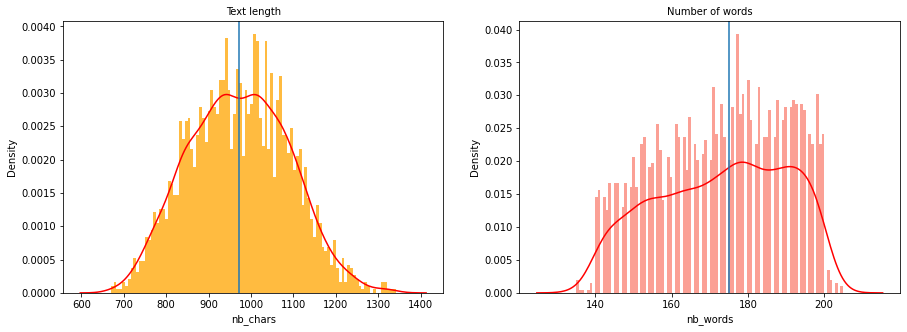

In [5]:
df_train = pd.read_csv(BASE_DATA_PATH / "train.csv")
display(df_train.head(3))

# explore excerpt
df_train['nb_words'] = df_train.excerpt.apply(lambda x: len(x.split()))
df_train['nb_chars'] = df_train.excerpt.apply(lambda x: len(x))

# plot histograms
fix, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_train, x="nb_chars", bins=100, ax=ax[0],
             color='orange', edgecolor=None, stat='density')
sns.kdeplot(data=df_train, x="nb_chars", color='red', ax=ax[0])
ax[0].axvline(np.median(df_train.nb_chars), 0, np.max(df_train.nb_chars))
ax[0].set_title('Text length', fontsize=10)

sns.histplot(data=df_train, x="nb_words", bins=100, ax=ax[1],
             color='salmon', edgecolor=None, stat='density')
sns.kdeplot(data=df_train, x="nb_words", color='red', ax=ax[1])
ax[1].axvline(np.median(df_train.nb_words), 0, np.max(df_train.nb_words))
ax[1].set_title('Number of words', fontsize=10)

plt.show()

Values of the target : -3.676267773 -> 1.7113898269999999


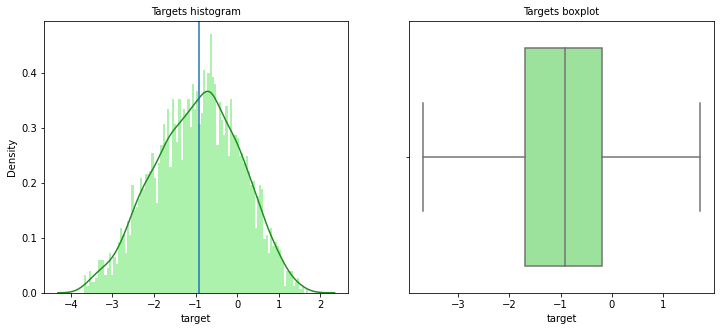

In [6]:
# target labels
labels = df_train['target']
print("Values of the target : {} -> {}".format(labels.min(), labels.max()))
      
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df_train, x="target", bins=100, ax=ax[0],
             color='lightgreen', edgecolor=None, stat='density')
sns.kdeplot(data=df_train, x="target", ax=ax[0], color='forestgreen')
ax[0].axvline(np.median(df_train.target), 0, np.max(df_train.target))
ax[0].set_title('Targets histogram', fontsize=10)

sns.boxplot(x=df_train["target"], ax=ax[1], color='lightgreen')
ax[1].set_title('Targets boxplot', fontsize=10)
plt.show()

# Utils

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value
    of a given object:
    val is the current value
    sum is the total sum of all increments
    count is the number of increments
    avg is the mean increment"""
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.cur_val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class Metric:
    """sums the squared residuals (target-excepted) for a period (epoch)
    and returns the rmse for the whole epoch data"""
    def __init__(self):
        self.sse = 0
        self.num_samples = 0
    
    def update(self, targets, predictions):
        predictions = flatten(predictions)
        self.sse += np.sum(np.square(targets - predictions))
        self.num_samples += len(targets)
        
    def get_rmse(self):
        rmse = np.sqrt(self.sse / self.num_samples)
        return rmse

def flatten(array):
    """takes an output array and flatten it
    returns a list"""
    my_list = []
    for i in range (len(array)):
        my_list.append(array[i][0])
    return np.array(my_list)

def asMinutes(s):
    """converts seconds to minutes"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """returns the time elapsed from the 'since' point
    and an estimation of the remaining time
    since : hour of the beginning
    percent : current % of progress compared to total length"""
    now = time.time()
    elapsed = now - since
    estimated = elapsed / (percent)
    remaining = estimated - elapsed
    return '%s (remain %s)' % (asMinutes(elapsed), asMinutes(remaining))

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    """initiate logger"""
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    
    logger.handlers.clear()
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    
    return logger

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def get_scheduler(optimizer):
    """instanciate a scheduler to update learning rate"""
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=CFG.T_max,
                                                         eta_min=CFG.min_lr,
                                                         last_epoch=-1)
    if CFG.scheduler == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer,
                                              step_size=30,
                                              gamma=0.1)
    return scheduler
    
def get_optimizer(model):
    """instanciate an optimizer"""
    if CFG.optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=CFG.lr,
                               weight_decay=CFG.weight_decay)
    if CFG.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr,
                                  weight_decay=CFG.weight_decay)
    if CFG.optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr,
                              weight_decay=CFG.weight_decay)
    return optimizer

In [8]:
sum = 0
nb = 0
targets = np.array([-1.6256722, -1.8930367, -1.643398, 0.11545783, -1.5774299])
predictions = np.array([[ 0.02553787], [-0.45123938], [-0.287227], [-0.19522502], [-0.17822093]])
#targets = np.array([2, 12, 3, 6])
#predictions = np.array([3.1, 11.1, 4.3, 5.4])

predictions = flatten(predictions)
sum += np.sum(np.square(targets - predictions))
nb += len(targets)
print(sum)
print(nb)
print(targets-predictions)
rmse = np.sqrt(sum / nb)
print(rmse)

print(np.sqrt(metrics.mean_squared_error(targets, predictions)))

8.69878356348217
5
[-1.65121007 -1.44179732 -1.356171    0.31068285 -1.39920897]
1.3189983747891556
1.3189983747891556


# Config

In [9]:
class CFG:
    model_name = "distilbert-base-uncased"
    model_path = "../input/distilbertbaseuncased"
    max_length = 256
    dropout_p = 0.4
    batch_size = 32
    n_epochs = 10
    weight_decay = 1e-6
    lr = 3e-4
    min_lr = 1e-6
    scheduler = "CosineAnnealingLR"
    optimizer = "Adam"
    T_max = 10
    seed = 42
    n_folds = 5    
    print_freq = 50
    num_workers = 4

# Dataset

In [10]:
class CommonLitDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_length):
    
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tokenized_input = self.tokenizer(row.excerpt, return_tensors="pt", 
                                        max_length=self.max_length, 
                                        padding="max_length", truncation=True)

        return {
                "ids": tokenized_input["input_ids"][0],
                "masks": tokenized_input["attention_mask"][0],
                "targets": torch.tensor(row.target).float()
        }

# Model

In [11]:
class TextRegressionModel(nn.Module):
    
    def __init__(self, model_name, dropout_p=0.1):
        super(TextRegressionModel, self).__init__()
        self.model = DistilBertModel.from_pretrained(CFG.model_path)
        self.features = nn.Linear(768, 768)
        self.dropout = nn.Dropout(dropout_p)
        self.regressor = nn.Linear(768, 1)
        
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,
                            attention_mask=attention_mask)
        output = output.last_hidden_state[:, 0]
        #output = F.relu(self.features(output.last_hidden_state[:, 0]))
        output = self.dropout(output)
        output = self.regressor(output)
        return output

# Train and eval Functions

In [12]:
def train_step(model, criterion, optimizer, data_loader, epoch, device=device):
    
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    train_loss = AverageMeter()
    metric = Metric()
    model.train()
    
    start = end = time.time()
    
    for step, batch in enumerate(data_loader):
        # update data loading time
        data_time.update(time.time() - end)
        
        # get data for the current batch
        input_ids = batch["ids"].to(device)
        attention_masks = batch["masks"].to(device)
        targets = batch["targets"].to(device)
        bs = input_ids.size(0)
        
        # compute output and loss
        output = model(input_ids, attention_masks)
        loss = criterion(output.squeeze(1), targets)
        train_loss.update(loss.item(), bs)
        # loss.item() is the avg of mse over the batch
        loss.backward()
        
        m_targets = targets.detach().cpu().numpy()
        m_predictions = output.detach().cpu().numpy()
        metric.update(targets=m_targets, predictions=m_predictions)
        
        # step optimizer
        optimizer.step()
        optimizer.zero_grad()
        
        # update batch time
        batch_time.update(time.time() - end)
        end = time.time()
        
        # if current step is a multiple of the printing param (or end)
        if step % CFG.print_freq == 0 or step == (len(data_loader) - 1):
            print('Epoch {0} [{1}/{2}]: '
                  #'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.cur_val:.4f} (avg {loss.avg:.4f}) '
                  .format(
                      epoch+1, step, len(data_loader), 
                      #batch_time=batch_time, data_time=data_time, 
                      loss=train_loss,
                      remain=timeSince(start, float(step+1)/len(data_loader)))
                 )

    rmse = metric.get_rmse()
    return train_loss.avg, rmse
        
    
def eval_step(model, criterion, data_loader, epoch, device=device):
    
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    eval_loss = AverageMeter()
    metric = Metric()
    model.eval()
    
    start = end = time.time()
    
    for step, batch in enumerate(data_loader):
        data_time.update(time.time() - end)
        
        input_ids = batch["ids"].to(device)
        attention_masks = batch["masks"].to(device)
        targets = batch["targets"].to(device)
        bs = input_ids.size(0)
        with torch.no_grad():
            output = model(input_ids, attention_masks)
        loss = criterion(output.squeeze(1), targets)
        eval_loss.update(loss.item(), bs)
        batch_time.update(time.time() - end)
        end = time.time()
        
        m_targets = targets.detach().cpu().numpy()
        m_predictions = output.detach().cpu().numpy()
        metric.update(targets=m_targets, predictions=m_predictions)

        if step % CFG.print_freq == 0 or step == (len(data_loader) - 1):
            print('EVAL - Epoch {0} [{1}/{2}]: '
                  'Loss: {loss.cur_val:.4f} (avg {loss.avg:.4f}) '
                  .format(epoch+1, step, len(data_loader),
                          loss=eval_loss
                      )
                 )
    rmse = metric.get_rmse()
    return eval_loss.avg, rmse

In [13]:
def train_loop(folds, fold):
    print('\n*** FOLD ', fold)
    
    # get indexes tagged for the current fold
    train_index = folds[folds["fold"] != fold].index
    valid_index = folds[folds["fold"] == fold].index
    
    # get data
    train_folds = folds.loc[train_index].reset_index(drop=True)
    valid_folds = folds.loc[valid_index].reset_index(drop=True)
    
    # create tokenizer and create dataset
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.model_path)
    tokenizer.save_pretrained(f"{CFG.model_name}_tokenizer")
    
    train_dataset = CommonLitDataset(df=train_folds, tokenizer=tokenizer,
                                     max_length=CFG.max_length)
    valid_dataset = CommonLitDataset(df=valid_folds, tokenizer=tokenizer,
                                     max_length=CFG.max_length)
    
    # create data loader with correct batch size
    train_data_loader = DataLoader(train_dataset, 
                                   batch_size=CFG.batch_size, 
                                   shuffle=True, 
                                   num_workers=CFG.num_workers, 
                                   pin_memory=True)
    valid_data_loader = DataLoader(valid_dataset, 
                                   batch_size=CFG.batch_size, 
                                   shuffle=False, 
                                   num_workers=CFG.num_workers, 
                                   pin_memory=True)
    
    # define scheduler, model, optimizer, loss
    model = TextRegressionModel(model_name=CFG.model_name, dropout_p=CFG.dropout_p)
    model.to(device)
    
    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)
    
    criterion = nn.MSELoss().to(device)
    best_loss = np.inf # initiate with positive infinity
    
    # iterate through epochs
    for epoch in range(CFG.n_epochs):
        print('\n')
        start_time = time.time()
        train_loss, train_rmse = train_step(model, criterion, optimizer, train_data_loader, epoch)
        eval_loss, eval_rmse = eval_step(model, criterion, valid_data_loader, epoch)
        scheduler.step()
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {train_loss:.4f} time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - avg_eval_loss: {eval_loss:.4f} - avg_rmse: {eval_rmse:.4f}')
        save_training(fold, epoch, train_loss, eval_loss, train_rmse, eval_rmse)
        
        # save best loss and model
        if eval_loss < best_loss:
            best_loss = eval_loss
            file_name = f"{CFG.model_name}_fold_{fold}_best.pth"
            print('  -> save model as', file_name)
            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict()
            }, file_name)

In [14]:
def save_training(fold, epoch, train_loss, val_loss, train_rmse, val_rmse):
    """stores the values of loss and rmse during training"""
    new_line = {'fold': fold, 'epoch': epoch,
                'train_loss': train_loss, 'val_loss': val_loss,
               'train_rmse': train_rmse, 'val_rmse': val_rmse}
    training_evals.loc[len(training_evals)] = new_line
    return training_evals

# Main

#### CV split

In [15]:
# separate the observations in CFG.n_folds folds (here = 5)
# the fold number is recorded in the 'fold' column of folds df
folds = df_train.copy()
Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for n, (train_idx, valid_idx) in enumerate(Fold.split(folds)):
    folds.loc[valid_idx, "fold"] = int(n)
    
folds["fold"] = folds["fold"].astype(int)
print('Number of observations per fold :\n')
print(folds.groupby(["fold"]).size())

Number of observations per fold :

fold
0    567
1    567
2    567
3    567
4    566
dtype: int64


In [16]:
def main():
    for fold in range(CFG.n_folds):
        gc.collect()
        torch.cuda.empty_cache()
        train_loop(folds, fold)

In [17]:
# inits
seed_torch(seed=CFG.seed)
LOGGER = init_logger()
training_evals = pd.DataFrame(columns=['fold', 'epoch', 'train_loss', 'val_loss',
                                       'train_rmse', 'val_rmse'])

# run training
main()


*** FOLD  0


Epoch 1 [0/71]: Elapsed 0m 2s (remain 2m 58s) Loss: 2.4172 (avg 2.4172) 
Epoch 1 [50/71]: Elapsed 0m 22s (remain 0m 8s) Loss: 0.6158 (avg 0.9403) 
Epoch 1 [70/71]: Elapsed 0m 30s (remain 0m 0s) Loss: 0.4107 (avg 0.8286) 
EVAL - Epoch 1 [0/18]: Loss: 0.2408 (avg 0.2408) 


Epoch 1 - avg_train_loss: 0.8286 time: 34s
Epoch 1 - avg_eval_loss: 0.4206 - avg_rmse: 0.6485


EVAL - Epoch 1 [17/18]: Loss: 0.6249 (avg 0.4206) 
  -> save model as distilbert-base-uncased_fold_0_best.pth


Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 22s) Loss: 0.4675 (avg 0.4675) 
Epoch 2 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.3758 (avg 0.2995) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1657 (avg 0.3071) 
EVAL - Epoch 2 [0/18]: Loss: 0.5233 (avg 0.5233) 


Epoch 2 - avg_train_loss: 0.3071 time: 33s
Epoch 2 - avg_eval_loss: 0.4745 - avg_rmse: 0.6888


EVAL - Epoch 2 [17/18]: Loss: 0.5572 (avg 0.4745) 


Epoch 3 [0/71]: Elapsed 0m 0s (remain 1m 3s) Loss: 0.2257 (avg 0.2257) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1511 (avg 0.1615) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1193 (avg 0.1607) 
EVAL - Epoch 3 [0/18]: Loss: 0.2723 (avg 0.2723) 


Epoch 3 - avg_train_loss: 0.1607 time: 32s
Epoch 3 - avg_eval_loss: 0.3645 - avg_rmse: 0.6037


EVAL - Epoch 3 [17/18]: Loss: 0.4591 (avg 0.3645) 
  -> save model as distilbert-base-uncased_fold_0_best.pth


Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 13s) Loss: 0.0662 (avg 0.0662) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0526 (avg 0.0895) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0663 (avg 0.0876) 
EVAL - Epoch 4 [0/18]: Loss: 0.2371 (avg 0.2371) 


Epoch 4 - avg_train_loss: 0.0876 time: 32s
Epoch 4 - avg_eval_loss: 0.3554 - avg_rmse: 0.5961


EVAL - Epoch 4 [17/18]: Loss: 0.5007 (avg 0.3554) 
  -> save model as distilbert-base-uncased_fold_0_best.pth


Epoch 5 [0/71]: Elapsed 0m 0s (remain 1m 0s) Loss: 0.0472 (avg 0.0472) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0526 (avg 0.0515) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0683 (avg 0.0493) 
EVAL - Epoch 5 [0/18]: Loss: 0.2531 (avg 0.2531) 


Epoch 5 - avg_train_loss: 0.0493 time: 32s
Epoch 5 - avg_eval_loss: 0.3536 - avg_rmse: 0.5946


EVAL - Epoch 5 [17/18]: Loss: 0.4826 (avg 0.3536) 
  -> save model as distilbert-base-uncased_fold_0_best.pth


Epoch 6 [0/71]: Elapsed 0m 0s (remain 1m 5s) Loss: 0.0309 (avg 0.0309) 
Epoch 6 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0243 (avg 0.0283) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0328 (avg 0.0279) 
EVAL - Epoch 6 [0/18]: Loss: 0.2922 (avg 0.2922) 


Epoch 6 - avg_train_loss: 0.0279 time: 32s
Epoch 6 - avg_eval_loss: 0.3553 - avg_rmse: 0.5961


EVAL - Epoch 6 [17/18]: Loss: 0.4495 (avg 0.3553) 


Epoch 7 [0/71]: Elapsed 0m 0s (remain 1m 8s) Loss: 0.0166 (avg 0.0166) 
Epoch 7 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0143 (avg 0.0187) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0312 (avg 0.0190) 
EVAL - Epoch 7 [0/18]: Loss: 0.2537 (avg 0.2537) 


Epoch 7 - avg_train_loss: 0.0190 time: 32s
Epoch 7 - avg_eval_loss: 0.3424 - avg_rmse: 0.5852


EVAL - Epoch 7 [17/18]: Loss: 0.4527 (avg 0.3424) 
  -> save model as distilbert-base-uncased_fold_0_best.pth


Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 43s) Loss: 0.0237 (avg 0.0237) 
Epoch 8 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0134 (avg 0.0133) 
Epoch 8 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0093 (avg 0.0130) 
EVAL - Epoch 8 [0/18]: Loss: 0.2519 (avg 0.2519) 


Epoch 8 - avg_train_loss: 0.0130 time: 33s
Epoch 8 - avg_eval_loss: 0.3501 - avg_rmse: 0.5917


EVAL - Epoch 8 [17/18]: Loss: 0.4718 (avg 0.3501) 


Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 16s) Loss: 0.0097 (avg 0.0097) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0083 (avg 0.0107) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0142 (avg 0.0110) 
EVAL - Epoch 9 [0/18]: Loss: 0.2531 (avg 0.2531) 


Epoch 9 - avg_train_loss: 0.0110 time: 32s
Epoch 9 - avg_eval_loss: 0.3458 - avg_rmse: 0.5881


EVAL - Epoch 9 [17/18]: Loss: 0.4647 (avg 0.3458) 


Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 23s) Loss: 0.0073 (avg 0.0073) 
Epoch 10 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0073 (avg 0.0105) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0104 (avg 0.0103) 
EVAL - Epoch 10 [0/18]: Loss: 0.2573 (avg 0.2573) 


Epoch 10 - avg_train_loss: 0.0103 time: 33s
Epoch 10 - avg_eval_loss: 0.3446 - avg_rmse: 0.5870


EVAL - Epoch 10 [17/18]: Loss: 0.4612 (avg 0.3446) 

*** FOLD  1


Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 47s) Loss: 2.2180 (avg 2.2180) 
Epoch 1 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.5046 (avg 1.1905) 
Epoch 1 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.7703 (avg 0.9884) 
EVAL - Epoch 1 [0/18]: Loss: 0.3397 (avg 0.3397) 


Epoch 1 - avg_train_loss: 0.9884 time: 33s
Epoch 1 - avg_eval_loss: 0.3872 - avg_rmse: 0.6222


EVAL - Epoch 1 [17/18]: Loss: 0.3281 (avg 0.3872) 
  -> save model as distilbert-base-uncased_fold_1_best.pth


Epoch 2 [0/71]: Elapsed 0m 0s (remain 1m 9s) Loss: 0.3102 (avg 0.3102) 
Epoch 2 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.3261 (avg 0.3156) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2794 (avg 0.3224) 
EVAL - Epoch 2 [0/18]: Loss: 0.3257 (avg 0.3257) 


Epoch 2 - avg_train_loss: 0.3224 time: 33s
Epoch 2 - avg_eval_loss: 0.4041 - avg_rmse: 0.6357


EVAL - Epoch 2 [17/18]: Loss: 0.5609 (avg 0.4041) 


Epoch 3 [0/71]: Elapsed 0m 0s (remain 1m 5s) Loss: 0.1558 (avg 0.1558) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1003 (avg 0.1639) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1712 (avg 0.1574) 
EVAL - Epoch 3 [0/18]: Loss: 0.3747 (avg 0.3747) 


Epoch 3 - avg_train_loss: 0.1574 time: 32s
Epoch 3 - avg_eval_loss: 0.4579 - avg_rmse: 0.6767


EVAL - Epoch 3 [17/18]: Loss: 0.5770 (avg 0.4579) 


Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 10s) Loss: 0.0919 (avg 0.0919) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1351 (avg 0.1011) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0802 (avg 0.0953) 
EVAL - Epoch 4 [0/18]: Loss: 0.3601 (avg 0.3601) 


Epoch 4 - avg_train_loss: 0.0953 time: 32s
Epoch 4 - avg_eval_loss: 0.3993 - avg_rmse: 0.6319


EVAL - Epoch 4 [17/18]: Loss: 0.4602 (avg 0.3993) 


Epoch 5 [0/71]: Elapsed 0m 1s (remain 1m 43s) Loss: 0.0451 (avg 0.0451) 
Epoch 5 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0568 (avg 0.0497) 
Epoch 5 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0648 (avg 0.0512) 
EVAL - Epoch 5 [0/18]: Loss: 0.3566 (avg 0.3566) 


Epoch 5 - avg_train_loss: 0.0512 time: 33s
Epoch 5 - avg_eval_loss: 0.3979 - avg_rmse: 0.6308


EVAL - Epoch 5 [17/18]: Loss: 0.4243 (avg 0.3979) 


Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 21s) Loss: 0.0303 (avg 0.0303) 
Epoch 6 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0246 (avg 0.0300) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0244 (avg 0.0300) 
EVAL - Epoch 6 [0/18]: Loss: 0.3442 (avg 0.3442) 


Epoch 6 - avg_train_loss: 0.0300 time: 33s
Epoch 6 - avg_eval_loss: 0.3932 - avg_rmse: 0.6270


EVAL - Epoch 6 [17/18]: Loss: 0.4468 (avg 0.3932) 


Epoch 7 [0/71]: Elapsed 0m 1s (remain 1m 18s) Loss: 0.0164 (avg 0.0164) 
Epoch 7 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0149 (avg 0.0193) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0269 (avg 0.0195) 
EVAL - Epoch 7 [0/18]: Loss: 0.3568 (avg 0.3568) 


Epoch 7 - avg_train_loss: 0.0195 time: 32s
Epoch 7 - avg_eval_loss: 0.3965 - avg_rmse: 0.6297


EVAL - Epoch 7 [17/18]: Loss: 0.4111 (avg 0.3965) 


Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 13s) Loss: 0.0125 (avg 0.0125) 
Epoch 8 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0173 (avg 0.0152) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0253 (avg 0.0148) 
EVAL - Epoch 8 [0/18]: Loss: 0.3508 (avg 0.3508) 


Epoch 8 - avg_train_loss: 0.0148 time: 32s
Epoch 8 - avg_eval_loss: 0.3941 - avg_rmse: 0.6278


EVAL - Epoch 8 [17/18]: Loss: 0.4379 (avg 0.3941) 


Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 12s) Loss: 0.0073 (avg 0.0073) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0124 (avg 0.0121) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0035 (avg 0.0118) 
EVAL - Epoch 9 [0/18]: Loss: 0.3501 (avg 0.3501) 


Epoch 9 - avg_train_loss: 0.0118 time: 32s
Epoch 9 - avg_eval_loss: 0.3940 - avg_rmse: 0.6277


EVAL - Epoch 9 [17/18]: Loss: 0.4399 (avg 0.3940) 


Epoch 10 [0/71]: Elapsed 0m 0s (remain 1m 7s) Loss: 0.0173 (avg 0.0173) 
Epoch 10 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0063 (avg 0.0105) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0151 (avg 0.0104) 
EVAL - Epoch 10 [0/18]: Loss: 0.3529 (avg 0.3529) 


Epoch 10 - avg_train_loss: 0.0104 time: 32s
Epoch 10 - avg_eval_loss: 0.3977 - avg_rmse: 0.6307


EVAL - Epoch 10 [17/18]: Loss: 0.4311 (avg 0.3977) 

*** FOLD  2


Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 23s) Loss: 1.1950 (avg 1.1950) 
Epoch 1 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.4409 (avg 0.8255) 
Epoch 1 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.3972 (avg 0.7418) 
EVAL - Epoch 1 [0/18]: Loss: 0.5565 (avg 0.5565) 


Epoch 1 - avg_train_loss: 0.7418 time: 32s
Epoch 1 - avg_eval_loss: 0.5020 - avg_rmse: 0.7085


EVAL - Epoch 1 [17/18]: Loss: 0.5775 (avg 0.5020) 
  -> save model as distilbert-base-uncased_fold_2_best.pth


Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 37s) Loss: 0.3479 (avg 0.3479) 
Epoch 2 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.2789 (avg 0.3207) 
Epoch 2 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.2465 (avg 0.3185) 
EVAL - Epoch 2 [0/18]: Loss: 0.4048 (avg 0.4048) 


Epoch 2 - avg_train_loss: 0.3185 time: 33s
Epoch 2 - avg_eval_loss: 0.3664 - avg_rmse: 0.6053


EVAL - Epoch 2 [17/18]: Loss: 0.3623 (avg 0.3664) 
  -> save model as distilbert-base-uncased_fold_2_best.pth


Epoch 3 [0/71]: Elapsed 0m 1s (remain 1m 20s) Loss: 0.1749 (avg 0.1749) 
Epoch 3 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.2442 (avg 0.2019) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1709 (avg 0.1888) 
EVAL - Epoch 3 [0/18]: Loss: 0.5228 (avg 0.5228) 


Epoch 3 - avg_train_loss: 0.1888 time: 32s
Epoch 3 - avg_eval_loss: 0.3970 - avg_rmse: 0.6301


EVAL - Epoch 3 [17/18]: Loss: 0.3361 (avg 0.3970) 


Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 13s) Loss: 0.1235 (avg 0.1235) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0774 (avg 0.1251) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1265 (avg 0.1218) 
EVAL - Epoch 4 [0/18]: Loss: 0.5995 (avg 0.5995) 


Epoch 4 - avg_train_loss: 0.1218 time: 32s
Epoch 4 - avg_eval_loss: 0.4481 - avg_rmse: 0.6694


EVAL - Epoch 4 [17/18]: Loss: 0.4640 (avg 0.4481) 


Epoch 5 [0/71]: Elapsed 0m 0s (remain 1m 2s) Loss: 0.1384 (avg 0.1384) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0538 (avg 0.0764) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0433 (avg 0.0720) 
EVAL - Epoch 5 [0/18]: Loss: 0.4453 (avg 0.4453) 


Epoch 5 - avg_train_loss: 0.0720 time: 32s
Epoch 5 - avg_eval_loss: 0.3672 - avg_rmse: 0.6060


EVAL - Epoch 5 [17/18]: Loss: 0.3286 (avg 0.3672) 


Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 27s) Loss: 0.0365 (avg 0.0365) 
Epoch 6 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0270 (avg 0.0407) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0596 (avg 0.0410) 
EVAL - Epoch 6 [0/18]: Loss: 0.4606 (avg 0.4606) 


Epoch 6 - avg_train_loss: 0.0410 time: 33s
Epoch 6 - avg_eval_loss: 0.3762 - avg_rmse: 0.6134


EVAL - Epoch 6 [17/18]: Loss: 0.3664 (avg 0.3762) 


Epoch 7 [0/71]: Elapsed 0m 1s (remain 1m 25s) Loss: 0.0219 (avg 0.0219) 
Epoch 7 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0340 (avg 0.0285) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0180 (avg 0.0273) 
EVAL - Epoch 7 [0/18]: Loss: 0.4508 (avg 0.4508) 


Epoch 7 - avg_train_loss: 0.0273 time: 32s
Epoch 7 - avg_eval_loss: 0.3675 - avg_rmse: 0.6062


EVAL - Epoch 7 [17/18]: Loss: 0.3606 (avg 0.3675) 


Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 12s) Loss: 0.0148 (avg 0.0148) 
Epoch 8 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0165 (avg 0.0179) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0178 (avg 0.0183) 
EVAL - Epoch 8 [0/18]: Loss: 0.4214 (avg 0.4214) 


Epoch 8 - avg_train_loss: 0.0183 time: 33s
Epoch 8 - avg_eval_loss: 0.3592 - avg_rmse: 0.5993


EVAL - Epoch 8 [17/18]: Loss: 0.3364 (avg 0.3592) 
  -> save model as distilbert-base-uncased_fold_2_best.pth


Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 38s) Loss: 0.0130 (avg 0.0130) 
Epoch 9 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0132 (avg 0.0144) 
Epoch 9 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0127 (avg 0.0147) 
EVAL - Epoch 9 [0/18]: Loss: 0.4229 (avg 0.4229) 


Epoch 9 - avg_train_loss: 0.0147 time: 33s
Epoch 9 - avg_eval_loss: 0.3607 - avg_rmse: 0.6005


EVAL - Epoch 9 [17/18]: Loss: 0.3503 (avg 0.3607) 


Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 13s) Loss: 0.0102 (avg 0.0102) 
Epoch 10 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0114 (avg 0.0132) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0290 (avg 0.0133) 
EVAL - Epoch 10 [0/18]: Loss: 0.4198 (avg 0.4198) 


Epoch 10 - avg_train_loss: 0.0133 time: 32s
Epoch 10 - avg_eval_loss: 0.3603 - avg_rmse: 0.6003


EVAL - Epoch 10 [17/18]: Loss: 0.3495 (avg 0.3603) 

*** FOLD  3


Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 10s) Loss: 1.9764 (avg 1.9764) 
Epoch 1 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.5574 (avg 0.9275) 
Epoch 1 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.6207 (avg 0.8370) 
EVAL - Epoch 1 [0/18]: Loss: 0.3323 (avg 0.3323) 


Epoch 1 - avg_train_loss: 0.8370 time: 32s
Epoch 1 - avg_eval_loss: 0.4650 - avg_rmse: 0.6819


EVAL - Epoch 1 [17/18]: Loss: 0.4279 (avg 0.4650) 
  -> save model as distilbert-base-uncased_fold_3_best.pth


Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 13s) Loss: 0.4945 (avg 0.4945) 
Epoch 2 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.2259 (avg 0.3709) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.3691 (avg 0.3612) 
EVAL - Epoch 2 [0/18]: Loss: 0.2961 (avg 0.2961) 


Epoch 2 - avg_train_loss: 0.3612 time: 33s
Epoch 2 - avg_eval_loss: 0.3958 - avg_rmse: 0.6291


EVAL - Epoch 2 [17/18]: Loss: 0.2371 (avg 0.3958) 
  -> save model as distilbert-base-uncased_fold_3_best.pth


Epoch 3 [0/71]: Elapsed 0m 1s (remain 1m 26s) Loss: 0.0891 (avg 0.0891) 
Epoch 3 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0854 (avg 0.1846) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1206 (avg 0.1814) 
EVAL - Epoch 3 [0/18]: Loss: 0.2327 (avg 0.2327) 


Epoch 3 - avg_train_loss: 0.1814 time: 33s
Epoch 3 - avg_eval_loss: 0.4314 - avg_rmse: 0.6568


EVAL - Epoch 3 [17/18]: Loss: 0.2236 (avg 0.4314) 


Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 21s) Loss: 0.1060 (avg 0.1060) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2032 (avg 0.1315) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1722 (avg 0.1350) 
EVAL - Epoch 4 [0/18]: Loss: 0.2882 (avg 0.2882) 


Epoch 4 - avg_train_loss: 0.1350 time: 32s
Epoch 4 - avg_eval_loss: 0.4128 - avg_rmse: 0.6425


EVAL - Epoch 4 [17/18]: Loss: 0.2036 (avg 0.4128) 


Epoch 5 [0/71]: Elapsed 0m 0s (remain 1m 7s) Loss: 0.0812 (avg 0.0812) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0642 (avg 0.0976) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0373 (avg 0.0917) 
EVAL - Epoch 5 [0/18]: Loss: 0.1904 (avg 0.1904) 


Epoch 5 - avg_train_loss: 0.0917 time: 32s
Epoch 5 - avg_eval_loss: 0.3832 - avg_rmse: 0.6190


EVAL - Epoch 5 [17/18]: Loss: 0.1744 (avg 0.3832) 
  -> save model as distilbert-base-uncased_fold_3_best.pth


Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 26s) Loss: 0.0455 (avg 0.0455) 
Epoch 6 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0650 (avg 0.0543) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0611 (avg 0.0564) 
EVAL - Epoch 6 [0/18]: Loss: 0.2060 (avg 0.2060) 


Epoch 6 - avg_train_loss: 0.0564 time: 33s
Epoch 6 - avg_eval_loss: 0.3715 - avg_rmse: 0.6095


EVAL - Epoch 6 [17/18]: Loss: 0.1729 (avg 0.3715) 
  -> save model as distilbert-base-uncased_fold_3_best.pth


Epoch 7 [0/71]: Elapsed 0m 1s (remain 2m 1s) Loss: 0.0225 (avg 0.0225) 
Epoch 7 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0360 (avg 0.0357) 
Epoch 7 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0210 (avg 0.0348) 
EVAL - Epoch 7 [0/18]: Loss: 0.1898 (avg 0.1898) 


Epoch 7 - avg_train_loss: 0.0348 time: 33s
Epoch 7 - avg_eval_loss: 0.3778 - avg_rmse: 0.6147


EVAL - Epoch 7 [17/18]: Loss: 0.1588 (avg 0.3778) 


Epoch 8 [0/71]: Elapsed 0m 1s (remain 2m 3s) Loss: 0.0270 (avg 0.0270) 
Epoch 8 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0185 (avg 0.0248) 
Epoch 8 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0177 (avg 0.0239) 
EVAL - Epoch 8 [0/18]: Loss: 0.1896 (avg 0.1896) 


Epoch 8 - avg_train_loss: 0.0239 time: 33s
Epoch 8 - avg_eval_loss: 0.3782 - avg_rmse: 0.6150


EVAL - Epoch 8 [17/18]: Loss: 0.1671 (avg 0.3782) 


Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 24s) Loss: 0.0150 (avg 0.0150) 
Epoch 9 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0071 (avg 0.0173) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0129 (avg 0.0172) 
EVAL - Epoch 9 [0/18]: Loss: 0.1890 (avg 0.1890) 


Epoch 9 - avg_train_loss: 0.0172 time: 32s
Epoch 9 - avg_eval_loss: 0.3745 - avg_rmse: 0.6120


EVAL - Epoch 9 [17/18]: Loss: 0.1677 (avg 0.3745) 


Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 15s) Loss: 0.0115 (avg 0.0115) 
Epoch 10 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0110 (avg 0.0148) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0250 (avg 0.0150) 
EVAL - Epoch 10 [0/18]: Loss: 0.1917 (avg 0.1917) 


Epoch 10 - avg_train_loss: 0.0150 time: 32s
Epoch 10 - avg_eval_loss: 0.3751 - avg_rmse: 0.6125


EVAL - Epoch 10 [17/18]: Loss: 0.1686 (avg 0.3751) 

*** FOLD  4


Epoch 1 [0/71]: Elapsed 0m 1s (remain 2m 10s) Loss: 2.9816 (avg 2.9816) 
Epoch 1 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.6984 (avg 0.9078) 
Epoch 1 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.3010 (avg 0.8016) 
EVAL - Epoch 1 [0/18]: Loss: 0.3948 (avg 0.3948) 


Epoch 1 - avg_train_loss: 0.8016 time: 33s
Epoch 1 - avg_eval_loss: 0.3727 - avg_rmse: 0.6105


EVAL - Epoch 1 [17/18]: Loss: 0.3838 (avg 0.3727) 
  -> save model as distilbert-base-uncased_fold_4_best.pth


Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 10s) Loss: 0.3027 (avg 0.3027) 
Epoch 2 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2091 (avg 0.3892) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.3382 (avg 0.3855) 
EVAL - Epoch 2 [0/18]: Loss: 0.4056 (avg 0.4056) 


Epoch 2 - avg_train_loss: 0.3855 time: 33s
Epoch 2 - avg_eval_loss: 0.4703 - avg_rmse: 0.6858


EVAL - Epoch 2 [17/18]: Loss: 0.4468 (avg 0.4703) 


Epoch 3 [0/71]: Elapsed 0m 0s (remain 1m 7s) Loss: 0.2943 (avg 0.2943) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2345 (avg 0.2480) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1705 (avg 0.2472) 
EVAL - Epoch 3 [0/18]: Loss: 0.3494 (avg 0.3494) 


Epoch 3 - avg_train_loss: 0.2472 time: 33s
Epoch 3 - avg_eval_loss: 0.4135 - avg_rmse: 0.6430


EVAL - Epoch 3 [17/18]: Loss: 0.3671 (avg 0.4135) 


Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 20s) Loss: 0.1249 (avg 0.1249) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2244 (avg 0.1442) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1491 (avg 0.1398) 
EVAL - Epoch 4 [0/18]: Loss: 0.3071 (avg 0.3071) 


Epoch 4 - avg_train_loss: 0.1398 time: 33s
Epoch 4 - avg_eval_loss: 0.3740 - avg_rmse: 0.6115


EVAL - Epoch 4 [17/18]: Loss: 0.4717 (avg 0.3740) 


Epoch 5 [0/71]: Elapsed 0m 0s (remain 1m 8s) Loss: 0.0658 (avg 0.0658) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0863 (avg 0.0798) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0604 (avg 0.0787) 
EVAL - Epoch 5 [0/18]: Loss: 0.3004 (avg 0.3004) 


Epoch 5 - avg_train_loss: 0.0787 time: 33s
Epoch 5 - avg_eval_loss: 0.3784 - avg_rmse: 0.6151


EVAL - Epoch 5 [17/18]: Loss: 0.4673 (avg 0.3784) 


Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 20s) Loss: 0.0604 (avg 0.0604) 
Epoch 6 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0612 (avg 0.0486) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0400 (avg 0.0465) 
EVAL - Epoch 6 [0/18]: Loss: 0.3080 (avg 0.3080) 


Epoch 6 - avg_train_loss: 0.0465 time: 33s
Epoch 6 - avg_eval_loss: 0.3688 - avg_rmse: 0.6073


EVAL - Epoch 6 [17/18]: Loss: 0.4475 (avg 0.3688) 
  -> save model as distilbert-base-uncased_fold_4_best.pth


Epoch 7 [0/71]: Elapsed 0m 1s (remain 1m 14s) Loss: 0.0319 (avg 0.0319) 
Epoch 7 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0421 (avg 0.0308) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0213 (avg 0.0302) 
EVAL - Epoch 7 [0/18]: Loss: 0.2879 (avg 0.2879) 


Epoch 7 - avg_train_loss: 0.0302 time: 33s
Epoch 7 - avg_eval_loss: 0.3585 - avg_rmse: 0.5987


EVAL - Epoch 7 [17/18]: Loss: 0.4313 (avg 0.3585) 
  -> save model as distilbert-base-uncased_fold_4_best.pth


Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 21s) Loss: 0.0237 (avg 0.0237) 
Epoch 8 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0140 (avg 0.0228) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0152 (avg 0.0226) 
EVAL - Epoch 8 [0/18]: Loss: 0.2856 (avg 0.2856) 


Epoch 8 - avg_train_loss: 0.0226 time: 32s
Epoch 8 - avg_eval_loss: 0.3612 - avg_rmse: 0.6010


EVAL - Epoch 8 [17/18]: Loss: 0.4512 (avg 0.3612) 


Epoch 9 [0/71]: Elapsed 0m 0s (remain 1m 2s) Loss: 0.0182 (avg 0.0182) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0101 (avg 0.0173) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0198 (avg 0.0177) 
EVAL - Epoch 9 [0/18]: Loss: 0.2855 (avg 0.2855) 


Epoch 9 - avg_train_loss: 0.0177 time: 32s
Epoch 9 - avg_eval_loss: 0.3619 - avg_rmse: 0.6016


EVAL - Epoch 9 [17/18]: Loss: 0.4357 (avg 0.3619) 


Epoch 10 [0/71]: Elapsed 0m 0s (remain 1m 7s) Loss: 0.0151 (avg 0.0151) 
Epoch 10 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0085 (avg 0.0139) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0133 (avg 0.0143) 
EVAL - Epoch 10 [0/18]: Loss: 0.2874 (avg 0.2874) 


Epoch 10 - avg_train_loss: 0.0143 time: 32s
Epoch 10 - avg_eval_loss: 0.3617 - avg_rmse: 0.6014


EVAL - Epoch 10 [17/18]: Loss: 0.4347 (avg 0.3617) 


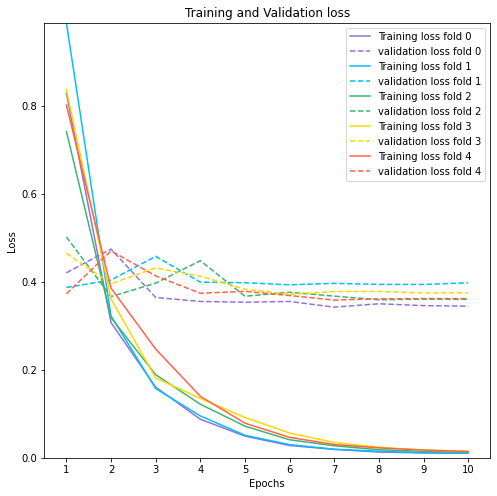

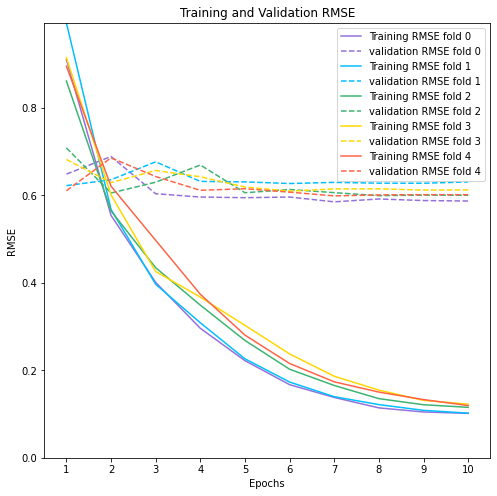

In [18]:
epochs = range(1, CFG.n_epochs + 1)
colors = ['mediumpurple', 'deepskyblue', 'mediumseagreen', 'gold', 'tomato']

# loss curve
fig = plt.figure(figsize=(8, 8))
max_y = 0
for f in range(CFG.n_folds):
    loss_train = training_evals.loc[training_evals.fold == f, 'train_loss']
    loss_val = training_evals.loc[training_evals.fold == f, 'val_loss']
    curmax = max(max(loss_train), max(loss_val))
    if curmax > max_y:
        max_y=curmax
    plt.plot(epochs, loss_train, c=colors[f], label='Training loss fold {}'.format(f))
    plt.plot(epochs, loss_val, c=colors[f], linestyle='dashed',
             label='validation loss fold {}'.format(f))

plt.title('Training and Validation loss')
plt.xticks(range(0, CFG.n_epochs + 1))
plt.xlim(0.5, CFG.n_epochs + 0.5)
plt.ylim(0, max_y)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.show()

# RMSE
max_y = 0
fig = plt.figure(figsize=(8, 8))
for f in range(CFG.n_folds):
    rmse_train = training_evals.loc[training_evals.fold == f, 'train_rmse']
    rmse_val = training_evals.loc[training_evals.fold == f, 'val_rmse']
    curmax = max(max(rmse_train), max(rmse_val))
    if curmax > max_y:
        max_y=curmax
    plt.plot(epochs, rmse_train, c=colors[f], label='Training RMSE fold {}'.format(f))
    plt.plot(epochs, rmse_val, c=colors[f], linestyle='dashed',
             label='validation RMSE fold {}'.format(f))
plt.title('Training and Validation RMSE')
plt.xticks(range(0, CFG.n_epochs + 1))
plt.xlim(0.5, CFG.n_epochs + 0.5)
plt.ylim(0, max_y)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.show()

# Inference

In [19]:
class CommonLitDataset_test(Dataset):
    
    def __init__(self, df, tokenizer, max_length):
    
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        tokenized_input = self.tokenizer(row.excerpt, return_tensors="pt", 
                                        max_length=self.max_length, 
                                        padding="max_length", truncation=True)

        return {
                "ids": tokenized_input["input_ids"][0],
                "masks": tokenized_input["attention_mask"][0]
        }

In [20]:
def inference(model, states, data_loader, device=device):
    """ runs inference for the test set
    takes each state (cf fold) and computes the mean of the results"""
    results = []
    n_state = 0
    with torch.no_grad():
        for state in states:
            state_results = []
            print('State {}/{}'.format(n_state + 1, len(states)))
            model.load_state_dict(state)
            model.to(device)
            model.eval()
            
            for step, batch in enumerate(data_loader):
                input_ids = batch["ids"].to(device)
                attention_masks = batch["masks"].to(device)
                output = model(input_ids, attention_masks)
                predictions = flatten(output.detach().cpu().numpy())
                state_results.extend(predictions)
    
            results.append(state_results)
            n_state += 1
    # mean
    mean_results = np.mean(results, axis=0)

    return results, mean_results

In [21]:
# get previous states from k fold
states = [torch.load(f"distilbert-base-uncased_fold_{f}_best.pth")["model"]
          for f in range(CFG.n_folds)]

# build model
model_inf = TextRegressionModel(CFG.model_name, CFG.dropout_p)

In [22]:
# build dataset with no target
tokenizer = DistilBertTokenizer.from_pretrained(CFG.model_path)

df_train = pd.read_csv(BASE_DATA_PATH / "train.csv")
test_dataset = CommonLitDataset_test(df_train, tokenizer, CFG.max_length)

data_loader_test = DataLoader(test_dataset,
                              batch_size=CFG.batch_size, shuffle=False)

In [23]:
# predict outputs
res_states, mean_res = inference(model_inf, states, data_loader_test, device)

State 1/5
State 2/5
State 3/5
State 4/5
State 5/5


RMSE on train dataset : 0.2066


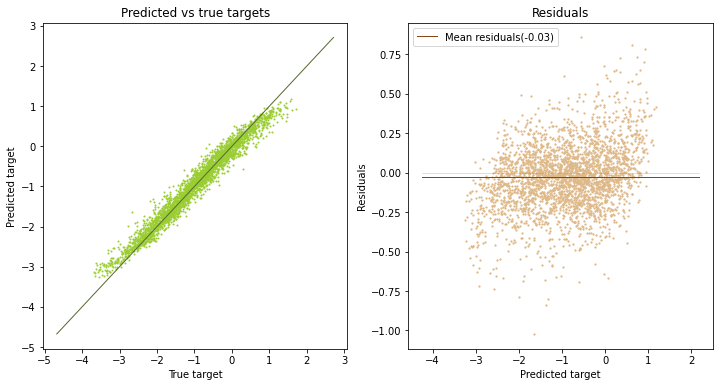

In [24]:
y_pred = mean_res
y_true = df_train.target

# compute RMSE on training set
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
print('RMSE on train dataset :', round(rmse, 4))

# plot results
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
xmin = np.min(y_true)-1
xmax = np.max(y_true)+1
axes[0].scatter(y_true, y_pred, color='yellowgreen', s=1)
axes[0].plot([xmin, xmax], [xmin, xmax],
             color='darkolivegreen',linewidth=1)
axes[0].set_xlabel('True target')
axes[0].set_ylabel('Predicted target')
axes[0].set_title('Predicted vs true targets')

residuals = y_true - y_pred
moy_residuals = np.mean(residuals)
lab = 'Mean residuals({})'.format(np.round(moy_residuals, decimals=2))

xmin = np.min(y_pred) - 1
xmax = np.max(y_pred) + 1
axes[1].scatter(y_pred, residuals, color='burlywood', s=1.5)
axes[1].plot([xmin, xmax], [0, 0], color='grey', alpha=0.5, linewidth=0.5)
axes[1].plot([xmin, xmax], [moy_residuals, moy_residuals],
             color='saddlebrown', linewidth=1, label=lab)
axes[1].set_xlabel('Predicted target')
axes[1].set_ylabel('Residuals')
axes[1].legend()
axes[1].set_title('Residuals')

plt.show()

# Test set (7 entries)

In [25]:
# build test dataset
tokenizer = DistilBertTokenizer.from_pretrained(CFG.model_path)

df_test = pd.read_csv(BASE_DATA_PATH / "test.csv")
test_dataset = CommonLitDataset_test(df_test, tokenizer, CFG.max_length)

data_loader_test = DataLoader(test_dataset,
                              batch_size=CFG.batch_size, shuffle=False)

# get outputs
out_states, out_mean = inference(model_inf, states, data_loader_test, device)

State 1/5
State 2/5
State 3/5
State 4/5
State 5/5


In [26]:
# build submission file
df_sub = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
df_sub["target"] = out_mean
df_sub.to_csv("submission.csv",index=False)
df_sub

,id,target
0,c0f722661,-0.624186
1,f0953f0a5,-0.635926
2,0df072751,-0.400671
3,04caf4e0c,-2.235944
4,0e63f8bea,-2.163043
5,12537fe78,-0.569525
6,965e592c0,0.118903
